In [1]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from timf.tsld.tsld import Sophistication


evaluation_data = EvaluationData()
tampering = Tampering()    
data_service = DataService()
timf = TIMF(data_service)
data = evaluation_data.get_data()
sophistication = Sophistication()


def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Inputs are arrays/Series with values 'T' or 'C'
    """
    y_true = (pd.Series(y_true_labels) == 'T').astype(int)
    y_pred = (pd.Series(y_pred_labels) == 'T').astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None

    return accuracy, precision, recall, auc

def _to_bin_labels(y):
    """Map labels to 0/1 where 'T' is positive (1), everything else is 0."""
    return np.array([1 if str(v) == 'T' else 0 for v in y], dtype=int)

def safe_auc(y_true_labels, y_scores):
    """
    Robust AUC:
    - returns np.nan if empty or only one class present
    - expects y_true_labels like ['T','C',...] and y_scores numeric
    """
    if y_true_labels is None or y_scores is None:
        return np.nan
    if len(y_true_labels) == 0 or len(y_scores) == 0:
        return np.nan

    y_true_bin = _to_bin_labels(y_true_labels)
    y_scores = np.asarray(y_scores, dtype=float)

    # lengths must match
    if y_true_bin.shape[0] != y_scores.shape[0]:
        raise ValueError(f"AUC length mismatch: y_true={len(y_true_bin)} vs y_score={len(y_scores)}")

    # AUC needs both classes
    if np.unique(y_true_bin).size < 2:
        return np.nan

    return float(roc_auc_score(y_true_bin, y_scores))

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Your existing label-based metrics (Accuracy / Precision / Recall).
    Assumes positive class is 'T'.
    """
    y_true_bin = _to_bin_labels(y_true_labels)
    y_pred_bin = _to_bin_labels(y_pred_labels)

    acc = float(accuracy_score(y_true_bin, y_pred_bin))
    prec = float(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    rec = float(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    return acc, prec, rec


Loaded existing evaluation data from CSV.


In [2]:

tampering_percentages = list(range(50, 60, 40))

tampering_types = ["N","K","S"]  # Naive, Knowledgeable, Sophisticated

availability = 1
repliocation_mic = 5
# tampering_types = ["N"]
        
results = []

results_acc = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():
            # print(assessing_mic)
            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # remote_data = data[data['gen_microcell'] != assessing_mic].reset_index(drop=True)

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:repliocation_mic]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            # remote_data_set = full_df[full_df['gen_microcell'] != assessing_mic].copy()

            # remote_data_set = data[data['gen_microcell'] != assessing_mic].copy()

            remote_data_set = bma_tampered_df.copy()

            rng = np.random.default_rng(42)  # fixed seed for reproducibility
            uni_mic = remote_data_set['gen_microcell'].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 1)),
                replace=False
            )

            remote_available = remote_data_set[remote_data_set['gen_microcell'].isin(selected_mics)].copy()
            data_service.set_remote_data(remote_available)

            correct_available = data[
                (data['gen_microcell'] != assessing_mic) &
                (data['gen_microcell'].isin(selected_mics))
            ].copy()

            data_service.set_correct_data(correct_available)

            

            microcell_data_all =pd.DataFrame()
            for provider in df_microcell['providerid'].unique():
                _, df_tda, time_df = timf.trust_assessment(provider, assessing_mic)
                microcell_data_all= pd.concat([microcell_data_all, df_tda], ignore_index=True).reset_index(drop=True)
                # print(df_tda['label'].value_counts())

            pred = sophistication.detect_sophistication(bma_tampered_df, microcell_data_all.copy(), [0.3,0.1,0.2,0.1,0.1,0.2])

            results_acc.append({
                "tampering_type": tampering_type,
                "tampering_percentage": tampering_percentage,
                "assessing_mic": assessing_mic,
                "pred": pred,
                "correct": int(pred == tampering_type),
            })





Experiment: Tampering Type=N, Percentage=50%
['M102'] maj_cluster= 0 centroid= {'Impact': 0.2579062780266479, 'Significance': 0.30014947653077556, 'Trend': 0.8516346906461273} -> N
['M110'] maj_cluster= 0 centroid= {'Impact': 0.25809770114916714, 'Significance': 0.29999999969999996, 'Trend': 0.8563648843048034} -> N
['M103'] maj_cluster= 1 centroid= {'Impact': 0.25387758620664264, 'Significance': 0.30032327556134153, 'Trend': 0.8611893588451764} -> N
['M117'] maj_cluster= 1 centroid= {'Impact': 0.25983170731681327, 'Significance': 0.29999999969999996, 'Trend': 0.8549270249398133} -> N
['M119'] maj_cluster= 1 centroid= {'Impact': 0.2562799054370959, 'Significance': 0.3000788019062953, 'Trend': 0.8578272745990889} -> N
['M115'] maj_cluster= 1 centroid= {'Impact': 0.24919409282675495, 'Significance': 0.2999999996999999, 'Trend': 0.8455920521267335} -> N
['M104'] maj_cluster= 1 centroid= {'Impact': 0.2593451282048688, 'Significance': 0.2999999996999999, 'Trend': 0.8585633622512071} -> N
['

In [3]:
results_acc

[{'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M102',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M110',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M103',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M117',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M119',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M115',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M104',
  'pred': 'N',
  'correct': 1},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M123',
  'pred': 'K',
  'correct': 0},
 {'tampering_type': 'N',
  'tampering_percentage': 50,
  'assessing_mic': 'M130',
  'pre

In [4]:
df_acc = pd.DataFrame(results_acc)

acc_by_type_pct = (
    df_acc
    .groupby(["tampering_type", "tampering_percentage"])["correct"]
    .mean()
    .mul(100)
    .reset_index(name="accuracy_%")
    .sort_values(["tampering_type", "tampering_percentage"])
)

print(acc_by_type_pct)


  tampering_type  tampering_percentage  accuracy_%
0              K                    50  100.000000
1              N                    50   63.157895
2              S                    50  100.000000


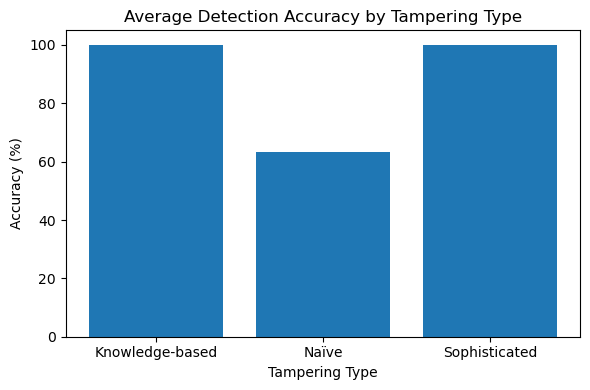

In [13]:
import matplotlib.pyplot as plt

# Aggregate accuracy per tampering type
acc_by_type = (
    acc_by_type_pct
    .groupby("tampering_type")["accuracy_%"]
    .mean()
    .reset_index()
)

# Optional: prettier labels
label_map = {"N": "Naïve", "K": "Knowledge-based", "S": "Sophisticated"}
acc_by_type["tampering_type"] = acc_by_type["tampering_type"].map(label_map)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(acc_by_type["tampering_type"], acc_by_type["accuracy_%"])

plt.xlabel("Tampering Type")
plt.ylabel("Accuracy (%)")
plt.title("Average Detection Accuracy by Tampering Type")

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ATTRS = ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']
D_COLS = [f"D_{a}" for a in ATTRS]

def compute_features_for_microcell(sophistication_obj, remote_data, tampered_data, mic_id, weight):
    df_sct = tampered_data.copy()

    # LT received only (your guaranteed local tampering)
    df_received = df_sct[(df_sct['origin'] == 'R') & (df_sct['label_test'] == 'LT')].copy()
    if df_received.empty:
        return pd.DataFrame(columns=["Impact","Significance","Trend"])

    # add D_* from remote origin
    df_received = sophistication_obj._process_received_data(df_received, remote_data)

    # numeric only
    for c in D_COLS:
        df_received[c] = pd.to_numeric(df_received[c], errors='coerce')
    df_received = df_received.dropna(subset=D_COLS).copy()

    # only this microcell
    df_received = df_received[df_received['currect_microcell'] == mic_id].copy()
    if df_received.empty:
        return pd.DataFrame(columns=["Impact","Significance","Trend"])

    # optional: filter zeros
    df_received = df_received[
        (df_received['speed'] != 0) &
        (df_received['latency'] != 0) &
        (df_received['bandwidth'] != 0) &
        (df_received['coverage'] != 0) &
        (df_received['reliability'] != 0) &
        (df_received['security'] != 0)
    ].copy()
    if df_received.empty:
        return pd.DataFrame(columns=["Impact","Significance","Trend"])

    impact = np.asarray(sophistication_obj._calculate_impact(df_received, weight), dtype=float)
    sig    = np.asarray(sophistication_obj._calculate_significance(df_received, weight), dtype=float)
    trend  = np.asarray(sophistication_obj._calculate_trend(df_received, remote_data), dtype=float)

    feats = pd.DataFrame({"Impact": impact, "Significance": sig, "Trend": trend})
    feats = feats.replace([np.inf, -np.inf], np.nan).dropna()
    return feats

def plot_microcell_3d(features_by_type, mic_id):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for ttype, feats in features_by_type.items():
        if feats is None or feats.empty:
            continue
        ax.scatter(feats["Impact"], feats["Significance"], feats["Trend"], label=ttype)

    ax.set_xlabel("Impact")
    ax.set_ylabel("Significance")
    ax.set_zlabel("Trend")
    ax.set_title(f"Microcell {mic_id}: Impact–Significance–Trend (LT Received)")
    ax.legend()
    plt.show()


In [6]:
def plot_microcell_3d_subplots(features_by_type, mic_id):
    """
    features_by_type: dict { 'N': DataFrame, 'K': DataFrame, 'S': DataFrame }
    """

    fig = plt.figure(figsize=(18, 5))

    tampering_order = ["N", "K", "S"]
    titles = {
        "N": "Naive",
        "K": "Knowledgeable",
        "S": "Sophisticated"
    }

    # -------------------------------------------------
    # Compute global axis limits for fair comparison
    # -------------------------------------------------
    all_feats = pd.concat(
        [df for df in features_by_type.values() if df is not None and not df.empty],
        ignore_index=True
    )

    if all_feats.empty:
        print("No data to plot.")
        return

    xlim = (all_feats["Impact"].min(), all_feats["Impact"].max())
    ylim = (all_feats["Significance"].min(), all_feats["Significance"].max())
    zlim = (all_feats["Trend"].min(), all_feats["Trend"].max())

    # -------------------------------------------------
    # Plot each sophistication level
    # -------------------------------------------------
    for i, ttype in enumerate(tampering_order, start=1):
        ax = fig.add_subplot(1, 3, i, projection="3d")

        feats = features_by_type.get(ttype, None)
        if feats is None or feats.empty:
            ax.set_title(f"{titles[ttype]} (no data)")
            continue

        ax.scatter(
            feats["Impact"],
            feats["Significance"],
            feats["Trend"],
            s=20,
            alpha=0.7
        )

        ax.set_title(f"{titles[ttype]} Tampering")
        ax.set_xlabel("Impact")
        ax.set_ylabel("Significance")
        ax.set_zlabel("Trend")

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)

    fig.suptitle(
        f"Microcell {mic_id}: Impact–Significance–Trend (LT Received Records)",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


In [18]:
features_by_microcell = {}
weight = [0.3,0.1,0.2,0.1,0.1,0.2]
tampering_percentage = 50

for assessing_mic in data["gen_microcell"].unique():

    # init container for this microcell
    features_by_microcell[assessing_mic] = {}

    for tampering_type in ["N", "K", "S"]:

        full_df = data.copy()
        df_microcell = data[data["gen_microcell"] == assessing_mic].copy()
        remaining_df = data[data["gen_microcell"] != assessing_mic].copy()

        # -------- Remote tampering (BMA) --------
        bma_tampered_df = tampering.bma_tampering(
            remaining_df.reset_index(drop=True),
            tampering_percentage,
            tampering_type
        )

        # -------- Replication logic --------
        microcell_coords = full_df.groupby("gen_microcell")[["latitude", "longitude"]].first().reset_index()
        current_coords = microcell_coords[microcell_coords["gen_microcell"] == assessing_mic]

        df_microcell_part = df_microcell.copy()
        df_microcell_part["currect_microcell"] = assessing_mic
        replicated_parts = [df_microcell_part]

        if not current_coords.empty:
            lat1 = current_coords["latitude"].values[0]
            lon1 = current_coords["longitude"].values[0]

            for provider_id in df_microcell["providerid"].unique():
                provider_remote = bma_tampered_df[bma_tampered_df["providerid"] == provider_id]
                candidate_microcells = []

                for _, row in microcell_coords.iterrows():
                    if row["gen_microcell"] == assessing_mic:
                        continue
                    if (provider_remote["gen_microcell"] == row["gen_microcell"]).any():
                        dist = _haversine_km(lat1, lon1, row["latitude"], row["longitude"])
                        candidate_microcells.append((row["gen_microcell"], dist))

                candidate_microcells.sort(key=lambda x: x[1])
                nearby_microcells = [m for m, _ in candidate_microcells[:repliocation_mic]]

                if nearby_microcells:
                    df_remote = bma_tampered_df[
                        (bma_tampered_df["providerid"] == provider_id) &
                        (bma_tampered_df["gen_microcell"].isin(nearby_microcells))
                    ].drop_duplicates(subset="serviceid")

                    if not df_remote.empty:
                        df_remote["origin"] = "R"
                        df_remote["currect_microcell"] = assessing_mic
                        replicated_parts.append(df_remote)

        df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)

        # -------- Local tampering (SPA) --------
        spa_tampered_df = tampering.spa_tampering(
            df_microcell_replicated,
            type=tampering_type
        )

        # -------- TIMF --------
        data_service.set_local_data(spa_tampered_df.copy())
        remote_available = bma_tampered_df.copy()
        data_service.set_remote_data(remote_available)

        correct_available = data[data["gen_microcell"] != assessing_mic].copy()
        data_service.set_correct_data(correct_available)

        microcell_data_all = pd.DataFrame()
        for provider in df_microcell["providerid"].unique():
            _, df_tda, _ = timf.trust_assessment(provider, assessing_mic)
            microcell_data_all = pd.concat([microcell_data_all, df_tda], ignore_index=True)

        # ✅ collect features for THIS microcell + THIS tampering type
        features_by_microcell[assessing_mic][tampering_type] = compute_features_for_microcell(
            sophistication,
            remote_available,
            microcell_data_all.copy(),
            assessing_mic,   # <- use current microcell
            weight
        )


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def compute_majority_centers(features_by_type, n_clusters=3, random_state=42, normalize_01=True):
    """
    Returns a DataFrame of majority-cluster centers for one microcell:
    columns: [type, Significance, Trend, Impact]
    NOTE: Impact is Z-axis if you plot as (Significance, Trend, Impact).
    """

    # ---- optional global 0-1 normalization (within THIS microcell)
    cols = ["Impact", "Significance", "Trend"]
    if normalize_01:
        all_feats = pd.concat(
            [df for df in features_by_type.values() if df is not None and not df.empty],
            ignore_index=True
        )
        if all_feats.empty:
            return pd.DataFrame(columns=["type","Significance","Trend","Impact"])
        mins = all_feats[cols].min()
        maxs = all_feats[cols].max()
        def norm01(df):
            df = df.copy()
            df[cols] = (df[cols] - mins) / (maxs - mins + 1e-9)
            return df
        features_by_type = {
            k: (norm01(v) if v is not None and not v.empty else v)
            for k, v in features_by_type.items()
        }

    majority_centers = []
    for ttype in ["N", "K", "S"]:
        feats = features_by_type.get(ttype)
        if feats is None or feats.empty or len(feats) < n_clusters:
            continue

        # cluster in standardized space (stable)
        X = feats[["Significance", "Trend", "Impact"]].to_numpy(dtype=float)
        Xs = StandardScaler().fit_transform(X)

        km = KMeans(n_clusters=n_clusters, n_init=30, random_state=random_state)
        labels = km.fit_predict(Xs)

        tmp = feats.copy()
        tmp["cluster"] = labels
        maj_cluster = int(tmp["cluster"].value_counts().idxmax())

        centroid = tmp[tmp["cluster"] == maj_cluster][["Significance","Trend","Impact"]].mean()

        majority_centers.append({
            "type": ttype,
            "Significance": float(centroid["Significance"]),
            "Trend": float(centroid["Trend"]),
            "Impact": float(centroid["Impact"]),
        })

    return pd.DataFrame(majority_centers)


In [24]:
import matplotlib.pyplot as plt

def plot_all_microcell_centers(features_by_microcell, n_clusters=3, random_state=42,
                               normalize_01=True, label_points=False):

    rows = []
    for mic_id, features_by_type in features_by_microcell.items():
        centers = compute_majority_centers(
            features_by_type,
            n_clusters=n_clusters,
            random_state=random_state,
            normalize_01=normalize_01
        )
        if centers.empty:
            continue
        centers["microcell"] = mic_id
        rows.append(centers)

    if not rows:
        print("No centers found to plot.")
        return pd.DataFrame()

    all_centers = pd.concat(rows, ignore_index=True)

    titles = {"N": "Naive", "K": "Knowledgeable", "S": "Sophisticated"}
    type_colors  = {"N": "tab:blue", "K": "tab:orange", "S": "tab:green"}
    type_markers = {"N": "o", "K": "^", "S": "s"}

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    for ttype in ["N", "K", "S"]:
        sub = all_centers[all_centers["type"] == ttype]
        if sub.empty:
            continue
        ax.scatter(
            sub["Significance"], sub["Trend"], sub["Impact"],
            s=70,
            marker=type_markers[ttype],
            color=type_colors[ttype],
            label=titles[ttype],
            alpha=0.85
        )

        if label_points:
            for _, r in sub.iterrows():
                ax.text(r["Significance"], r["Trend"], r["Impact"], r["microcell"], fontsize=7)

    ax.set_xlabel("Significance")
    ax.set_ylabel("Trend")
    ax.set_zlabel("Impact")
    ax.set_title("Majority Cluster Centers Across Microcells")
    ax.legend(loc="upper left")

    # If normalized_01=True, these are correct
    if normalize_01:
        ax.set_xlim(0, 0.1); ax.set_ylim(0, 1); ax.set_zlim(0, 1)

    plt.tight_layout()
    plt.show()

    return all_centers


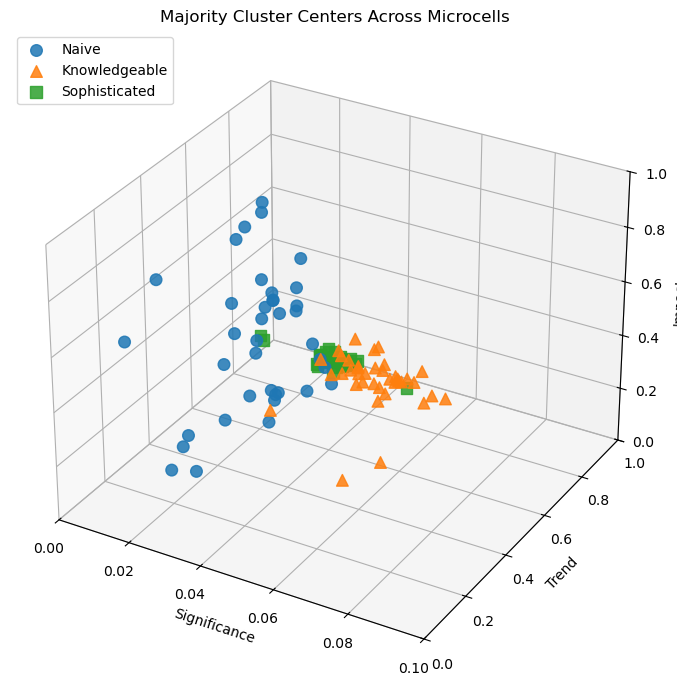

In [25]:
all_centers_df = plot_all_microcell_centers(
    features_by_microcell,
    n_clusters=3,
    normalize_01=True,     # gives you fixed 0–1 axes
    label_points=False     # set True if you want microcell IDs on points
)


In [7]:
features_by_type = {}
target_mic = "M102"
weight = [0.3,0.1,0.2,0.1,0.1,0.2]

for tampering_type in ["N","K","S"]:
    for tampering_percentage in [50]:

        for assessing_mic in data['gen_microcell'].unique():
            if assessing_mic != target_mic:
                continue

            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            df_microcell_part = df_microcell.copy()
            df_microcell_part['currect_microcell'] = assessing_mic
            replicated_parts = [df_microcell_part]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                for provider_id in df_microcell['providerid'].unique():
                    provider_remote = bma_tampered_df[bma_tampered_df['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:repliocation_mic]]

                    if nearby_microcells:
                        df_remote = bma_tampered_df[
                            (bma_tampered_df['providerid'] == provider_id) &
                            (bma_tampered_df['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

            df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- TIMF --------
            data_service.set_local_data(spa_tampered_df.copy())

            remote_available = bma_tampered_df.copy()
            data_service.set_remote_data(remote_available)

            correct_available = data[data['gen_microcell'] != assessing_mic].copy()
            data_service.set_correct_data(correct_available)

            microcell_data_all = pd.DataFrame()
            for provider in df_microcell['providerid'].unique():
                _, df_tda, _ = timf.trust_assessment(provider, assessing_mic)
                microcell_data_all = pd.concat([microcell_data_all, df_tda], ignore_index=True)

            # ✅ collect features
            features_by_type[tampering_type] = compute_features_for_microcell(
                sophistication,
                remote_available,
                microcell_data_all.copy(),
                target_mic,
                weight
            )


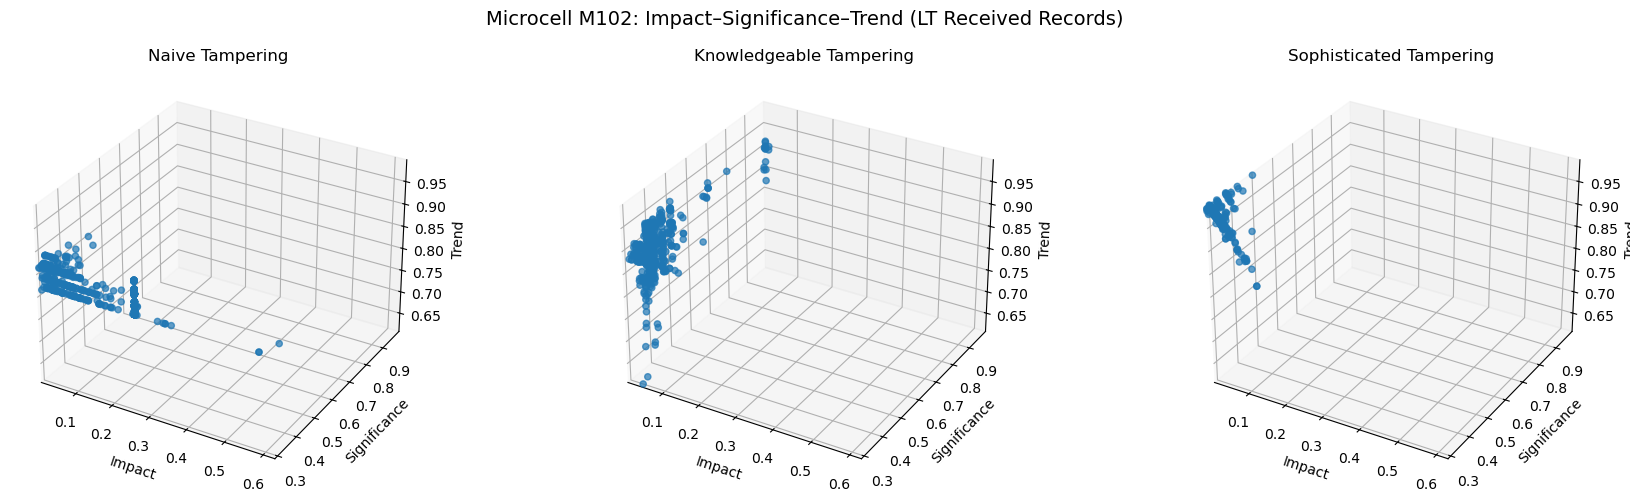

In [8]:
plot_microcell_3d_subplots(features_by_type, target_mic)


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_microcell_clusters_subplots(features_by_type, mic_id,
                                     n_clusters=3,
                                     random_state=42):

    fig = plt.figure(figsize=(24, 5))

    tampering_order = ["N", "K", "S"]
    titles = {"N": "Naive", "K": "Knowledgeable", "S": "Sophisticated"}

    type_colors  = {"N": "tab:blue", "K": "tab:orange", "S": "tab:green"}
    type_markers = {"N": "o", "K": "^", "S": "s"}
    cluster_colors = ["tab:blue", "tab:orange", "tab:green"]

    # ------------------------------------
    # global normalization to [0,1]
    # ------------------------------------
    all_feats = pd.concat(
        [df for df in features_by_type.values() if df is not None and not df.empty],
        ignore_index=True
    )
    if all_feats.empty:
        print("No data to plot.")
        return

    cols = ["Impact", "Significance", "Trend"]
    mins = all_feats[cols].min()
    maxs = all_feats[cols].max()

    def norm01(df):
        df = df.copy()
        df[cols] = (df[cols] - mins) / (maxs - mins + 1e-9)
        return df

    # normalize every type (so all share same 0-1 scale)
    features_by_type = {
        k: (norm01(v) if v is not None and not v.empty else v)
        for k, v in features_by_type.items()
    }

    # fixed axis limits: X=Significance, Y=Trend, Z=Impact
    xlim, ylim, zlim = (0, 1), (0, 1), (0, 1)

    majority_centers = []

    # ------------------------------------
    # 1–3: clustered plots (N, K, S)
    # ------------------------------------
    for i, ttype in enumerate(tampering_order, start=1):
        ax = fig.add_subplot(1, 4, i, projection="3d")
        feats = features_by_type.get(ttype)

        if feats is None or feats.empty or len(feats) < n_clusters:
            ax.set_title(f"{titles[ttype]} (no data)")
            ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
            continue

        # Swap axis order for clustering: [Significance, Trend, Impact]
        X = feats[["Significance", "Trend", "Impact"]].to_numpy(dtype=float)
        Xs = StandardScaler().fit_transform(X)

        km = KMeans(n_clusters=n_clusters, n_init=30, random_state=random_state)
        labels = km.fit_predict(Xs)

        feats = feats.copy()
        feats["cluster"] = labels
        maj_cluster = int(feats["cluster"].value_counts().idxmax())

        # plot clusters (X=Significance, Y=Trend, Z=Impact)
        for c in range(n_clusters):
            sub = feats[feats["cluster"] == c]
            ax.scatter(
                sub["Significance"], sub["Trend"], sub["Impact"],
                s=18 if c != maj_cluster else 40,
                alpha=0.25 if c != maj_cluster else 0.9,
                color=cluster_colors[c],
                label="Majority cluster" if c == maj_cluster else None
            )

        # majority centroid
        centroid = feats[feats["cluster"] == maj_cluster][
            ["Impact", "Significance", "Trend"]
        ].mean()

        majority_centers.append({
            "type": ttype,
            "Impact": float(centroid["Impact"]),
            "Significance": float(centroid["Significance"]),
            "Trend": float(centroid["Trend"])
        })

        ax.scatter(
            centroid["Significance"], centroid["Trend"], centroid["Impact"],
            s=220, marker="X", color="red", label="Majority centroid"
        )

        ax.set_title(f"{titles[ttype]} Tampering")
        ax.set_xlabel("Significance")   # X
        ax.set_ylabel("Trend")          # Y
        ax.set_zlabel("Impact")         # Z
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)

        if i == 1:
            ax.legend(loc="upper left", fontsize=8)

    # ------------------------------------
    # 4th subplot: ONLY majority centers
    # ------------------------------------
    ax4 = fig.add_subplot(1, 4, 4, projection="3d")
    centers_df = pd.DataFrame(majority_centers)

    for _, row in centers_df.iterrows():
        ttype = row["type"]
        ax4.scatter(
            row["Significance"], row["Trend"], row["Impact"],
            s=260,
            marker=type_markers[ttype],
            color=type_colors[ttype],
            label=titles[ttype]
        )

    ax4.set_title("Majority Cluster Centers")
    ax4.set_xlabel("Significance")
    ax4.set_ylabel("Trend")
    ax4.set_zlabel("Impact")
    ax4.legend(loc="upper left", fontsize=9)

    ax4.set_xlim(xlim); ax4.set_ylim(ylim); ax4.set_zlim(zlim)

    fig.suptitle(
        f"Microcell {mic_id}: Clusters + Majority Centers Summary",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

    return centers_df


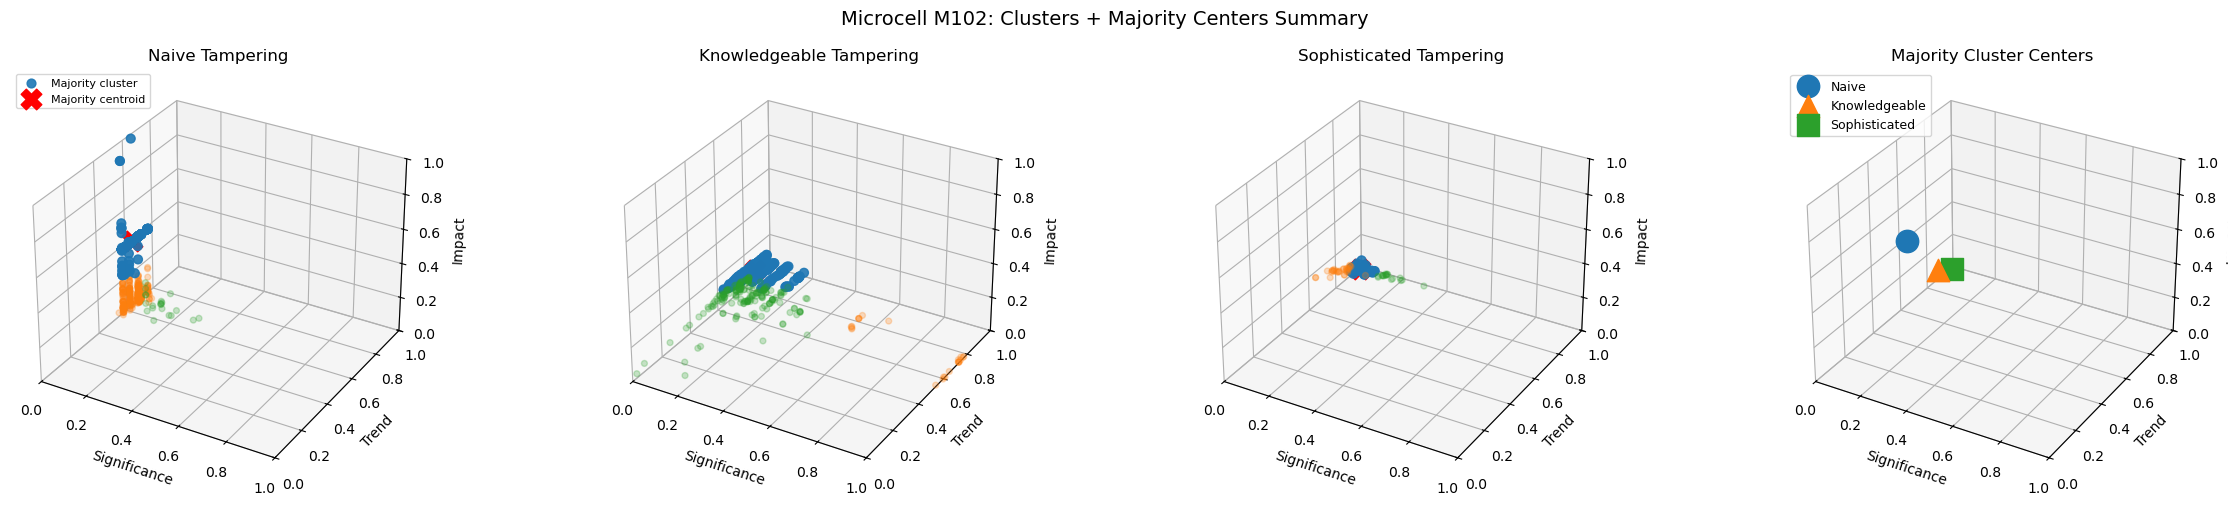

,type,Impact,Significance,Trend
0,N,0.408351,0.020107,0.622498
1,K,0.106731,0.036255,0.826648
2,S,0.026465,0.022949,0.952097


In [17]:
plot_microcell_clusters_subplots(features_by_type, "M102")


In [ ]:

tampering_percentages = list(range(50, 60, 40))

tampering_types = ["N","K","S"]  # Naive, Knowledgeable, Sophisticated

availability = 1
repliocation_mic = 5
# tampering_types = ["N"]
        
results = []

results_acc = []

features_by_type = {}

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():
            # print(assessing_mic)
            full_df = data.copy()
            df_microcell = data[data['gen_microcell'] == assessing_mic].copy()
            remaining_df = data[data['gen_microcell'] != assessing_mic].copy()

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                remaining_df.reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # remote_data = data[data['gen_microcell'] != assessing_mic].reset_index(drop=True)

            # -------- Replication logic --------
            microcell_coords = full_df.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:repliocation_mic]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            # remote_data_set = full_df[full_df['gen_microcell'] != assessing_mic].copy()

            # remote_data_set = data[data['gen_microcell'] != assessing_mic].copy()

            remote_data_set = bma_tampered_df.copy()

            rng = np.random.default_rng(42)  # fixed seed for reproducibility
            uni_mic = remote_data_set['gen_microcell'].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 1)),
                replace=False
            )

            remote_available = remote_data_set[remote_data_set['gen_microcell'].isin(selected_mics)].copy()
            data_service.set_remote_data(remote_available)

            correct_available = data[
                (data['gen_microcell'] != assessing_mic) &
                (data['gen_microcell'].isin(selected_mics))
            ].copy()

            data_service.set_correct_data(correct_available)


            features_by_type[tampering_type] = sophistication.compute_features_for_microcell(  sophistication, spa_tampered_df, remote_available, "M102", [0.3,0.1,0.2,0.1,0.1,0.2] )

        

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def visualize_clusters_kmeans(new_df, k=3, random_state=0):
    feats = ['Impact', 'Significance', 'Trend']
    X = new_df[feats].to_numpy()

    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    labels = km.fit_predict(Xs)

    # majority cluster
    counts = np.bincount(labels)
    maj = counts.argmax()

    # centers back to original feature space
    centers = scaler.inverse_transform(km.cluster_centers_)
    centers_df = pd.DataFrame(centers, columns=feats)

    # ---- Plot 1: Impact vs Trend ----
    plt.figure(figsize=(8, 6))
    plt.scatter(new_df['Impact'], new_df['Trend'], c=labels, alpha=0.7)
    for ci, center in enumerate(centers):
        plt.scatter(center[0], center[2], marker='X', s=200, edgecolors='black')
        plt.text(center[0], center[2], f"C{ci}", ha='center')
    plt.title(f'KMeans (k={k}) Impact vs Trend | Majority=C{maj} (n={counts[maj]})')
    plt.xlabel('Impact')
    plt.ylabel('Trend')
    plt.show()

    # ---- Plot 2: Significance vs Trend ----
    plt.figure(figsize=(8, 6))
    plt.scatter(new_df['Significance'], new_df['Trend'], c=labels, alpha=0.7)
    for ci, center in enumerate(centers):
        plt.scatter(center[1], center[2], marker='X', s=200, edgecolors='black')
        plt.text(center[1], center[2], f"C{ci}", ha='center')
    plt.title(f'KMeans (k={k}) Significance vs Trend | Majority=C{maj} (n={counts[maj]})')
    plt.xlabel('Significance')
    plt.ylabel('Trend')
    plt.show()

    return labels, maj, counts, centers_df

# Run it


In [ ]:
spa_tampered_df

In [ ]:
out.to_csv("tttt.csv")

In [ ]:
import numpy as np
import pandas as pd

ATTRS = ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']


class SophisticationDetector:
    """
    Computes (Impact, Significance, Trend) scores for *detected tampered* records
    and optionally classifies them into {Naive, Knowledgeable, Sophisticated}.

    Key upgrade vs your previous version:
      - adds percentile-based threshold calibration (fit_thresholds)
      - supports automatic calibration inside detect() if thresholds not fitted yet
      - safer handling of missing/invalid references
    """

    def __init__(
        self,
        attrs=ATTRS,
        microcell_col="gen_microcell",
        beta_low=0.0,
        beta_high=5.0,
        significance_mode="any_change",   # any_change / positive_only / negative_only
        impact_mode="magnitude",          # magnitude / positive_only
        q_impact_hi=0.80,
        q_impact_mid=0.50,
        q_sig_hi=0.80,
        q_sig_mid=0.50,
        q_trend_lo=0.30,
        q_trend_mid=0.60,
    ):
        self.attrs = list(attrs)
        self.microcell_col = microcell_col
        self.beta_low = float(beta_low)
        self.beta_high = float(beta_high)
        self.significance_mode = significance_mode
        self.impact_mode = impact_mode

        # percentile hyperparams (you can tune these)
        self.q_impact_hi = float(q_impact_hi)
        self.q_impact_mid = float(q_impact_mid)
        self.q_sig_hi = float(q_sig_hi)
        self.q_sig_mid = float(q_sig_mid)
        self.q_trend_lo = float(q_trend_lo)
        self.q_trend_mid = float(q_trend_mid)

        # thresholds will be learned via fit_thresholds()
        self._thresholds_fitted = False
        self.impact_hi = None
        self.impact_mid = None
        self.sig_hi = None
        self.sig_mid = None
        self.trend_lo = None
        self.trend_mid = None

    # -----------------------------
    # Public API
    # -----------------------------
    def detect(
        self,
        correct_data: pd.DataFrame,
        tampered_data: pd.DataFrame,
        weight,
        classify=True,
        auto_fit_thresholds=True,
        fit_scope="global",  # "global" or "per_microcell"
    ):
        """
        Returns dict: {microcell_id: df_scores}

        auto_fit_thresholds:
          - If classify=True and thresholds haven't been fitted yet,
            auto_fit_thresholds=True will fit them using the scores produced in this call.
        fit_scope:
          - "global": fit thresholds once using all scores in this call
          - "per_microcell": fit separate thresholds for each microcell (less stable; use only if needed)
        """
        if tampered_data is None or tampered_data.empty:
            return {}

        df = tampered_data.copy()

        # 1) only keep records that TDA flagged as tampered
        if "label" not in df.columns:
            raise ValueError("tampered_data must contain a 'label' column with 'T'/'C'.")
        df = df[df["label"] == "T"].copy()
        if df.empty:
            return {}

        # 2) ensure required columns exist
        self._validate_columns(df, required=["providerid", "serviceid", "origin", self.microcell_col] + self.attrs)
        self._validate_columns(correct_data, required=["providerid", "serviceid", self.microcell_col] + self.attrs)

        # 3) compute scores per microcell (first pass, no labels yet)
        out = {}
        all_scores_for_fit = []

        for mic_id, df_mic in df.groupby(self.microcell_col):
            df_mic = df_mic.copy().reset_index(drop=True)

            # Build D_* reference columns for BOTH origin types
            df_mic = self._add_reference_columns(df_mic, correct_data, mic_id)

            # Drop rows where reference could not be computed
            for a in self.attrs:
                df_mic = df_mic[pd.to_numeric(df_mic[f"D_{a}"], errors="coerce").notna()]
            if df_mic.empty:
                continue

            impact = self._compute_impact(df_mic, weight, mode=self.impact_mode)
            significance = self._compute_significance(df_mic, weight, mode=self.significance_mode)
            trend = self._compute_trend(df_mic, correct_data)

            df_scores = pd.DataFrame({
                "Impact": impact,
                "Significance": significance,
                "Trend": trend
            })

            df_scores = df_scores[pd.to_numeric(df_scores["Trend"], errors="coerce").notna()].reset_index(drop=True)
            if df_scores.empty:
                continue

            out[mic_id] = df_scores

            if fit_scope == "global":
                all_scores_for_fit.append(df_scores)

        # nothing to return
        if not out:
            return {}

        # -----------------------------
        # Threshold fitting + labeling
        # -----------------------------
        if classify:
            if auto_fit_thresholds and not self._thresholds_fitted:
                if fit_scope == "global":
                    df_fit = pd.concat(all_scores_for_fit, ignore_index=True) if all_scores_for_fit else None
                    if df_fit is None or df_fit.empty:
                        # can't fit thresholds; fall back to "Sophisticated"
                        for mic_id in out:
                            out[mic_id]["PredSoph"] = "Sophisticated"
                        return out
                    self.fit_thresholds(df_fit)

                elif fit_scope == "per_microcell":
                    # Fit thresholds per microcell (less stable; optional)
                    for mic_id, df_scores in out.items():
                        self.fit_thresholds(df_scores)
                        out[mic_id]["PredSoph"] = df_scores.apply(self._classify_row, axis=1)
                    return out

            # If still not fitted (e.g., auto_fit_thresholds=False), you must call fit_thresholds() manually
            if not self._thresholds_fitted:
                raise RuntimeError(
                    "Thresholds not fitted. Call fit_thresholds(df_scores) first, "
                    "or set auto_fit_thresholds=True."
                )

            # Apply classification using fitted thresholds
            for mic_id, df_scores in out.items():
                df_scores["PredSoph"] = df_scores.apply(self._classify_row, axis=1)

        return out

    # -----------------------------
    # Reference building (D_* columns)
    # -----------------------------
    def _add_reference_columns(self, df_mic: pd.DataFrame, correct_data: pd.DataFrame, mic_id):
        """
        Creates D_speed..D_security columns:
          - origin == 'R': D_* = origin record values matched by serviceid from correct_data
          - origin == 'G': D_* = provider mean from correct_data excluding this microcell
        """
        df_mic = df_mic.copy()

        for a in self.attrs:
            df_mic[f"D_{a}"] = np.nan

        # origin == 'R': match by serviceid
        mask_r = (df_mic["origin"] == "R")
        if mask_r.any():
            ref_r = correct_data.drop_duplicates(subset=["serviceid"]).set_index("serviceid")
            for a in self.attrs:
                df_mic.loc[mask_r, f"D_{a}"] = df_mic.loc[mask_r, "serviceid"].map(ref_r[a])

        # origin == 'G': provider mean excluding this microcell
        mask_g = (df_mic["origin"] == "G")
        if mask_g.any():
            for idx in df_mic.index[mask_g]:
                prov = df_mic.at[idx, "providerid"]
                provider_other = correct_data[
                    (correct_data["providerid"] == prov) &
                    (correct_data[self.microcell_col] != mic_id)
                ]

                if provider_other.shape[0] < 2:
                    continue

                mean_vals = provider_other[self.attrs].mean()
                for a in self.attrs:
                    df_mic.at[idx, f"D_{a}"] = mean_vals[a]

        return df_mic

    # -----------------------------
    # Core scoring functions
    # -----------------------------
    def _compute_delta(self, df):
        A = df[self.attrs].to_numpy(float)
        D = df[[f"D_{a}" for a in self.attrs]].to_numpy(float)
        return A - D

    def _compute_impact(self, df, weight, mode="magnitude"):
        delta = self._compute_delta(df)
        w = np.array(weight, dtype=float)

        if w.size != len(self.attrs):
            raise ValueError(f"weight must have length {len(self.attrs)} to match attrs.")

        if mode == "positive_only":
            delta = np.clip(delta, 0, None)
        else:
            delta = np.abs(delta)

        return (delta * w).sum(axis=1)

    def _compute_significance(self, df, weight, mode="any_change"):
        delta = self._compute_delta(df)
        w = np.array(weight, dtype=float)

        if mode == "positive_only":
            changed = (delta > 0).astype(int)
        elif mode == "negative_only":
            changed = (delta < 0).astype(int)
        else:
            changed = (np.abs(delta) > 0).astype(int)

        num_changed = changed.sum(axis=1)
        num_changed = np.maximum(num_changed, 1)

        sig = (changed * w).sum(axis=1) / num_changed
        return sig

    def _compute_trend(self, df, correct_df):
        """
        Trend = 1 - (distance from provider mean) / (max possible distance)
        """
        out = np.full(len(df), np.nan, dtype=float)

        k = len(self.attrs)
        max_d = np.sqrt(k) * (self.beta_high - self.beta_low)

        for i in range(len(df)):
            prov = df.iloc[i]["providerid"]
            sid = df.iloc[i]["serviceid"]

            temp = correct_df[(correct_df["providerid"] == prov) & (correct_df["serviceid"] != sid)]
            if temp.shape[0] == 0:
                continue

            mean_vec = temp[self.attrs].to_numpy(float).mean(axis=0)
            rec_vec = df.iloc[i][self.attrs].to_numpy(float)

            d = float(np.linalg.norm(rec_vec - mean_vec))
            out[i] = max(0.0, min(1.0, 1.0 - d / max_d))

        return out

    # -----------------------------
    # Threshold fitting + classification
    # -----------------------------
    def fit_thresholds(self, df_scores: pd.DataFrame):
        """
        Fit thresholds from score distributions (percentile-based).
        Call once on a representative batch of scores.
        """
        if df_scores is None or df_scores.empty:
            raise ValueError("df_scores is empty; cannot fit thresholds.")

        df_scores = df_scores.copy()
        for c in ["Impact", "Significance", "Trend"]:
            df_scores[c] = pd.to_numeric(df_scores[c], errors="coerce")
        df_scores = df_scores.dropna(subset=["Impact", "Significance", "Trend"])
        if df_scores.empty:
            raise ValueError("df_scores has no valid numeric rows after cleaning.")

        self.impact_hi = float(df_scores["Impact"].quantile(self.q_impact_hi))
        self.impact_mid = float(df_scores["Impact"].quantile(self.q_impact_mid))

        self.sig_hi = float(df_scores["Significance"].quantile(self.q_sig_hi))
        self.sig_mid = float(df_scores["Significance"].quantile(self.q_sig_mid))

        self.trend_lo = float(df_scores["Trend"].quantile(self.q_trend_lo))
        self.trend_mid = float(df_scores["Trend"].quantile(self.q_trend_mid))

        self._thresholds_fitted = True

    def _classify_row(self, row):
        impact = float(row["Impact"])
        sig = float(row["Significance"])
        trend = float(row["Trend"])

        # Naive: large impact + many changed attributes + low mimicry (low trend)
        if impact >= self.impact_hi and sig >= self.sig_hi and trend <= self.trend_lo:
            return "Naive"

        # Knowledgeable: moderate impact/significance + medium mimicry
        if impact >= self.impact_mid and sig >= self.sig_mid and trend <= self.trend_mid:
            return "Knowledgeable"

        return "Sophisticated"

    # -----------------------------
    # Validation
    # -----------------------------
    @staticmethod
    def _validate_columns(df, required):
        missing = [c for c in required if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService

from sklearn.metrics import accuracy_score, confusion_matrix

# ============================================================
# SophisticationDetector (as defined by you) must be available
# ============================================================
# (Paste the SophisticationDetector class ABOVE this cell)

# ============================================================
# Setup
# ============================================================
evaluation_data = EvaluationData()
tampering = Tampering()

data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()

tampering_percentages = list(range(10, 100, 20))  # 10,30,50,70,90
tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated

WEIGHTS = [0.3, 0.1, 0.2, 0.1, 0.1, 0.2]
TRUE_MAP = {"N": "Naive", "K": "Knowledgeable", "S": "Sophisticated"}


def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c


# ============================================================
# Instantiate sophistication module
# IMPORTANT: microcell_col must match df_tda column name
# ============================================================
soph = SophisticationDetector(
    microcell_col="gen_microcell",      # change to "currect_microcell" if needed
    impact_mode="magnitude",            # works for SPA + BMA
    significance_mode="any_change"      # works for SPA + BMA
)

# ============================================================
# Run Experiment
# ============================================================
soph_rows = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data["gen_microcell"].unique():

            df_microcell = data[data["gen_microcell"] == assessing_mic]

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                data[data["gen_microcell"] != assessing_mic].reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # -------- Replication logic --------
            microcell_coords = data.groupby("gen_microcell")[["latitude", "longitude"]].first().reset_index()
            current_coords = microcell_coords[microcell_coords["gen_microcell"] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords["latitude"].values[0]
                lon1 = current_coords["longitude"].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, "currect_microcell"] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell["providerid"].unique():

                    provider_remote = remote_data[remote_data["providerid"] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row["gen_microcell"] == assessing_mic:
                            continue
                        if (provider_remote["gen_microcell"] == row["gen_microcell"]).any():
                            dist = _haversine_km(lat1, lon1, row["latitude"], row["longitude"])
                            candidate_microcells.append((row["gen_microcell"], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:10]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data["providerid"] == provider_id) &
                            (remote_data["gen_microcell"].isin(nearby_microcells))
                        ].drop_duplicates(subset="serviceid")

                        if not df_remote.empty:
                            df_remote["origin"] = "R"
                            df_remote["currect_microcell"] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(df_microcell_replicated, type=tampering_type)

            # -------- Set TIMF local data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Remote availability pool ---
            remote_data_set = data[data["gen_microcell"] != assessing_mic].copy()

            rng = np.random.default_rng(42)
            uni_mic = remote_data_set["gen_microcell"].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 0.8)),
                replace=False
            )

            remote_available = remote_data_set[remote_data_set["gen_microcell"].isin(selected_mics)].copy()
            data_service.set_remote_data(remote_available)

            # =====================================================
            # Run per-provider: TDA -> Sophistication
            # =====================================================
            for provider in df_microcell["providerid"].unique():

                _, df_tda, _ = timf.trust_assessment(provider, assessing_mic)
                if df_tda is None or df_tda.empty:
                    continue

                # ---------- Sophistication ----------
                # Use remote_available as "correct_data" reference
                # Recompute without classification first
# easiest way: just fit using current df_soph_all scores

                soph_out = soph.detect(
                    correct_data=remote_available,
                    tampered_data=df_tda,
                    weight=WEIGHTS,
                    classify=True
                )

                for mic_id, df_scores in soph_out.items():
                    if df_scores is None or df_scores.empty:
                        continue

                    df_scores = df_scores.copy()
                    df_scores["assessing_microcell"] = assessing_mic
                    df_scores["microcell_key"] = mic_id
                    df_scores["providerid"] = provider
                    df_scores["tampering_type"] = tampering_type
                    df_scores["tampering_percentage"] = tampering_percentage
                    df_scores["TrueSoph"] = TRUE_MAP[tampering_type]

                    soph_rows.append(df_scores)

# ============================================================
# Aggregate + Evaluate
# ============================================================
if len(soph_rows) == 0:
    raise RuntimeError("No sophistication outputs produced. Check df_tda columns and labels.")

df_soph_all = pd.concat(soph_rows, ignore_index=True)

soph.fit_thresholds(df_soph_all)

# Re-label with new thresholds
df_soph_all['PredSoph'] = df_soph_all.apply(soph._classify_row, axis=1)


overall_acc = accuracy_score(df_soph_all["TrueSoph"], df_soph_all["PredSoph"])
print("\nOverall sophistication accuracy:", overall_acc)

labels = ["Naive", "Knowledgeable", "Sophisticated"]
cm = confusion_matrix(df_soph_all["TrueSoph"], df_soph_all["PredSoph"], labels=labels)
print("\nConfusion matrix rows=True, cols=Pred:\n", cm)

acc_by_pct = (
    df_soph_all.assign(correct=(df_soph_all["TrueSoph"] == df_soph_all["PredSoph"]).astype(int))
    .groupby(["tampering_percentage"])["correct"]
    .mean()
    .reset_index(name="accuracy")
)
print("\nAccuracy by tampering percentage:\n", acc_by_pct)

# ============================================================
# Plots
# ============================================================

# 1) Impact vs Trend scatter (colored by PredSoph)
plt.figure(figsize=(6, 4))
for lab in labels:
    sub = df_soph_all[df_soph_all["PredSoph"] == lab]
    plt.scatter(sub["Impact"], sub["Trend"], alpha=0.55, label=lab)

plt.xlabel("Impact")
plt.ylabel("Trend")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy vs tampering percentage
plt.figure(figsize=(6, 4))
plt.plot(acc_by_pct["tampering_percentage"], acc_by_pct["accuracy"], marker="o")
plt.xlabel("Tampering Percentage (%)")
plt.ylabel("Sophistication Classification Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Histograms
for col in ["Impact", "Significance", "Trend"]:
    plt.figure(figsize=(6, 4))
    plt.hist(df_soph_all[col].astype(float).values, bins=30, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService

from sklearn.metrics import accuracy_score, confusion_matrix

# ============================================================
# SophisticationDetector (as defined by you) must be available
# ============================================================
# (Paste the SophisticationDetector class ABOVE this cell)

# ============================================================
# Setup
# ============================================================
evaluation_data = EvaluationData()
tampering = Tampering()

data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()

tampering_percentages = list(range(10, 100, 20))  # 10,30,50,70,90
tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated

WEIGHTS = [0.3, 0.1, 0.2, 0.1, 0.1, 0.2]
TRUE_MAP = {"N": "Naive", "K": "Knowledgeable", "S": "Sophisticated"}


def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c


# ============================================================
# Instantiate sophistication module
# IMPORTANT: microcell_col must match df_tda column name
# ============================================================
soph = SophisticationDetector(
    microcell_col="gen_microcell",      # change to "currect_microcell" if needed
    impact_mode="magnitude",            # works for SPA + BMA
    significance_mode="any_change"      # works for SPA + BMA
)

# ============================================================
# Run Experiment
# ============================================================
soph_rows = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data["gen_microcell"].unique():

            df_microcell = data[data["gen_microcell"] == assessing_mic]

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                data[data["gen_microcell"] != assessing_mic].reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # -------- Replication logic --------
            microcell_coords = data.groupby("gen_microcell")[["latitude", "longitude"]].first().reset_index()
            current_coords = microcell_coords[microcell_coords["gen_microcell"] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords["latitude"].values[0]
                lon1 = current_coords["longitude"].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, "currect_microcell"] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell["providerid"].unique():

                    provider_remote = remote_data[remote_data["providerid"] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row["gen_microcell"] == assessing_mic:
                            continue
                        if (provider_remote["gen_microcell"] == row["gen_microcell"]).any():
                            dist = _haversine_km(lat1, lon1, row["latitude"], row["longitude"])
                            candidate_microcells.append((row["gen_microcell"], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:10]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data["providerid"] == provider_id) &
                            (remote_data["gen_microcell"].isin(nearby_microcells))
                        ].drop_duplicates(subset="serviceid")

                        if not df_remote.empty:
                            df_remote["origin"] = "R"
                            df_remote["currect_microcell"] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(df_microcell_replicated, type=tampering_type)

            # -------- Set TIMF local data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Remote availability pool ---
            remote_data_set = data[data["gen_microcell"] != assessing_mic].copy()

            rng = np.random.default_rng(42)
            uni_mic = remote_data_set["gen_microcell"].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 0.8)),
                replace=False
            )

            remote_available = remote_data_set[remote_data_set["gen_microcell"].isin(selected_mics)].copy()
            data_service.set_remote_data(remote_available)

            # =====================================================
            # Run per-provider: TDA -> Sophistication
            # =====================================================
            for provider in df_microcell["providerid"].unique():

                _, df_tda, _ = timf.trust_assessment(provider, assessing_mic)
                if df_tda is None or df_tda.empty:
                    continue

                # ---------- Sophistication ----------
                # Use remote_available as "correct_data" reference
                soph_out = soph.detect(
                    correct_data=remote_available,
                    tampered_data=df_tda,
                    weight=WEIGHTS,
                    classify=True
                )

                for mic_id, df_scores in soph_out.items():
                    if df_scores is None or df_scores.empty:
                        continue

                    df_scores = df_scores.copy()
                    df_scores["assessing_microcell"] = assessing_mic
                    df_scores["microcell_key"] = mic_id
                    df_scores["providerid"] = provider
                    df_scores["tampering_type"] = tampering_type
                    df_scores["tampering_percentage"] = tampering_percentage
                    df_scores["TrueSoph"] = TRUE_MAP[tampering_type]

                    soph_rows.append(df_scores)

# ============================================================
# Aggregate + Evaluate
# ============================================================
if len(soph_rows) == 0:
    raise RuntimeError("No sophistication outputs produced. Check df_tda columns and labels.")

df_soph_all = pd.concat(soph_rows, ignore_index=True)

overall_acc = accuracy_score(df_soph_all["TrueSoph"], df_soph_all["PredSoph"])
print("\nOverall sophistication accuracy:", overall_acc)

labels = ["Naive", "Knowledgeable", "Sophisticated"]
cm = confusion_matrix(df_soph_all["TrueSoph"], df_soph_all["PredSoph"], labels=labels)
print("\nConfusion matrix rows=True, cols=Pred:\n", cm)

acc_by_pct = (
    df_soph_all.assign(correct=(df_soph_all["TrueSoph"] == df_soph_all["PredSoph"]).astype(int))
    .groupby(["tampering_percentage"])["correct"]
    .mean()
    .reset_index(name="accuracy")
)
print("\nAccuracy by tampering percentage:\n", acc_by_pct)

# ============================================================
# Plots
# ============================================================

# 1) Impact vs Trend scatter (colored by PredSoph)
plt.figure(figsize=(6, 4))
for lab in labels:
    sub = df_soph_all[df_soph_all["PredSoph"] == lab]
    plt.scatter(sub["Impact"], sub["Trend"], alpha=0.55, label=lab)

plt.xlabel("Impact")
plt.ylabel("Trend")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy vs tampering percentage
plt.figure(figsize=(6, 4))
plt.plot(acc_by_pct["tampering_percentage"], acc_by_pct["accuracy"], marker="o")
plt.xlabel("Tampering Percentage (%)")
plt.ylabel("Sophistication Classification Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Histograms
for col in ["Impact", "Significance", "Trend"]:
    plt.figure(figsize=(6, 4))
    plt.hist(df_soph_all[col].astype(float).values, bins=30, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService

from sklearn.metrics import accuracy_score, confusion_matrix

# ============================================================
# Setup
# ============================================================
evaluation_data = EvaluationData()
tampering = Tampering()

data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()

# You already have this class in your project
sophistication = SophisticationDetector()

tampering_percentages = list(range(10, 100, 20))  # 10,30,50,70,90
tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated

WEIGHTS = [0.3, 0.1, 0.2, 0.1, 0.1, 0.2]


# ============================================================
# Helpers
# ============================================================
def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c


def classify_sophistication(row):
    """
    Rule-based mapping from (Impact, Significance, Trend) -> class label.
    Adjust thresholds as needed after you see distributions.
    """
    impact = float(row["Impact"])
    sig = float(row["Significance"])
    trend = float(row["Trend"])

    # Example rules (simple + explainable)
    # Naive: high impact & significant changes but poor trend mimicry
    if impact >= 0.60 and sig >= 0.60 and trend <= 0.45:
        return "Naive"

    # Knowledgeable: moderate impact/significance, some mimicry but not strong
    if impact >= 0.35 and sig >= 0.35 and trend <= 0.65:
        return "Knowledgeable"

    # Sophisticated: lower/controlled impact + trend-aligned (mimicking)
    return "Sophisticated"


TRUE_MAP = {"N": "Naive", "K": "Knowledgeable", "S": "Sophisticated"}


# ============================================================
# Main experiment: run TDA -> run sophistication on detected T records
# ============================================================
soph_results = []  # will store record-level sophistication outputs

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data["gen_microcell"].unique():

            df_microcell = data[data["gen_microcell"] == assessing_mic]

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(
                data[data["gen_microcell"] != assessing_mic].reset_index(drop=True),
                tampering_percentage,
                tampering_type
            )
            remote_data = bma_tampered_df.copy()

            # -------- Replication logic --------
            microcell_coords = data.groupby("gen_microcell")[["latitude", "longitude"]].first().reset_index()
            current_coords = microcell_coords[microcell_coords["gen_microcell"] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords["latitude"].values[0]
                lon1 = current_coords["longitude"].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, "currect_microcell"] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell["providerid"].unique():

                    provider_remote = remote_data[remote_data["providerid"] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row["gen_microcell"] == assessing_mic:
                            continue
                        if (provider_remote["gen_microcell"] == row["gen_microcell"]).any():
                            dist = _haversine_km(lat1, lon1, row["latitude"], row["longitude"])
                            candidate_microcells.append((row["gen_microcell"], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:10]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data["providerid"] == provider_id) &
                            (remote_data["gen_microcell"].isin(nearby_microcells))
                        ].drop_duplicates(subset="serviceid")

                        if not df_remote.empty:
                            df_remote["origin"] = "R"
                            df_remote["currect_microcell"] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            remote_data_set = data[data["gen_microcell"] != assessing_mic].copy()

            # --- Select 80% of microcells (availability by microcell) ---
            rng = np.random.default_rng(42)
            uni_mic = remote_data_set["gen_microcell"].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 0.8)),
                replace=False
            )

            remote_available = remote_data_set[remote_data_set["gen_microcell"].isin(selected_mics)].copy()
            data_service.set_remote_data(remote_available)

            # =====================================================
            # Run per-provider
            # =====================================================
            for provider in df_microcell["providerid"].unique():

                # ---------- TDA ----------
                # returns: (something, df_tda, time_df)
                _, df_tda, _ = timf.trust_assessment(provider, assessing_mic)

                if df_tda is None or df_tda.empty:
                    continue

                # ---------- Sophistication (only on detected tampered rows inside Sophistication class) ----------
                soph_out = sophistication.detect_sophistication(
                    correct_data=df_microcell_replicated,  # reference set
                    tampered_data=df_tda,                  # output of TDA (must have label/origin)
                    weight=WEIGHTS
                )

                # soph_out is a dict: {microcell_id: df(Impact,Significance,Trend), ...}
                for mic_id, df_soph in soph_out.items():
                    if df_soph is None or df_soph.empty:
                        continue

                    df_soph = df_soph.copy()
                    df_soph["assessing_microcell"] = assessing_mic
                    df_soph["microcell_key"] = mic_id
                    df_soph["providerid"] = provider
                    df_soph["tampering_type"] = tampering_type
                    df_soph["tampering_percentage"] = tampering_percentage
                    df_soph["TrueSoph"] = TRUE_MAP[tampering_type]

                    soph_results.append(df_soph)

# ============================================================
# Aggregate outputs
# ============================================================
if len(soph_results) == 0:
    raise RuntimeError("No sophistication outputs were produced. Check df_tda labels and Sophistication filters.")

df_soph_all = pd.concat(soph_results, ignore_index=True)

# Drop any NC/invalid rows if they exist
for col in ["Impact", "Significance", "Trend"]:
    df_soph_all = df_soph_all[pd.to_numeric(df_soph_all[col], errors="coerce").notna()]
    df_soph_all[col] = df_soph_all[col].astype(float)

# Classify sophistication
df_soph_all["PredSoph"] = df_soph_all.apply(classify_sophistication, axis=1)

# ============================================================
# Evaluate
# ============================================================
overall_acc = accuracy_score(df_soph_all["TrueSoph"], df_soph_all["PredSoph"])
print("\nOverall sophistication accuracy:", overall_acc)

cm = confusion_matrix(
    df_soph_all["TrueSoph"],
    df_soph_all["PredSoph"],
    labels=["Naive", "Knowledgeable", "Sophisticated"]
)
print("\nConfusion matrix rows=True, cols=Pred (Naive,Knowledgeable,Sophisticated):\n", cm)

# Accuracy by tampering_percentage
acc_by_pct = (
    df_soph_all.assign(correct=(df_soph_all["TrueSoph"] == df_soph_all["PredSoph"]).astype(int))
    .groupby(["tampering_percentage"])["correct"]
    .mean()
    .reset_index(name="accuracy")
)
print("\nAccuracy by tampering percentage:\n", acc_by_pct)

# ============================================================
# Plots
# ============================================================

# 1) Scatter: Impact vs Trend (colored by PredSoph)
plt.figure(figsize=(6, 4))
for label in ["Naive", "Knowledgeable", "Sophisticated"]:
    sub = df_soph_all[df_soph_all["PredSoph"] == label]
    plt.scatter(sub["Impact"], sub["Trend"], alpha=0.55, label=label)

plt.xlabel("Impact")
plt.ylabel("Trend")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy vs tampering percentage
plt.figure(figsize=(6, 4))
plt.plot(acc_by_pct["tampering_percentage"], acc_by_pct["accuracy"], marker="o")
plt.xlabel("Tampering Percentage (%)")
plt.ylabel("Sophistication Classification Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Optional: show distributions of the three features
plt.figure(figsize=(6, 4))
plt.hist(df_soph_all["Impact"].values, bins=30, alpha=0.7)
plt.xlabel("Impact")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def dataframe_devide_to_microcell_dictionary(df):
    temp_dictionary={}
    unique_keys = df.gen_microcell.unique()
    for microcell in unique_keys:
        temp_dictionary["{}".format(microcell)] = df[df.gen_microcell==microcell]
    return temp_dictionary

In [ ]:

import pandas as pd


class Sophistication:
    def __init__(self):
        pass

    def detect_sophistication(self, correct_data, tampered_data, weight):
        results_review = {}

        df_sct = tampered_data
        df_sct = df_sct[df_sct['label'] == 'T']
        tampered_data = dataframe_devide_to_microcell_dictionary(df_sct)

        for key2, df2 in tampered_data.items():
            df2_received = df2[(df2['label'] == 'T') & (df2['origin'] == 'R')]
            df2_generated = df2[(df2['label'] == 'T') & (df2['origin'] == 'G')]

            if not df2_received.empty:
                df2_received = self._process_received_data(df2_received, correct_data)

            if not df2_generated.empty:
                df2_generated = self._process_generated_data(df2_generated, correct_data, key2)

            combined_microcell_df = pd.concat([df2_generated, df2_received])
            combined_microcell_df = combined_microcell_df[combined_microcell_df['D_speed'] != 'NC']
            combined_microcell_df = combined_microcell_df[(combined_microcell_df['speed'] != 0) &
                                        (combined_microcell_df['latency'] != 0) &
                                        (combined_microcell_df['bandwidth'] != 0) &
                                        (combined_microcell_df['coverage'] != 0) &
                                        (combined_microcell_df['reliability'] != 0) &
                                        (combined_microcell_df['security'] != 0)]
            combined_microcell_df=combined_microcell_df.reset_index(drop=True)
            nc_count = combined_microcell_df['D_speed'].value_counts().get('NC', 0)
            total_count = len(combined_microcell_df['D_speed'])

            # print("Microcell:", key2)
            # print("Count of 'NC':", nc_count)
            # print("Total count:", total_count)

            results_review[key2] = combined_microcell_df
        # print("*********second part************")
        out_data={}
        for key, df in results_review.items():
            df=df.reset_index(drop=True)
            
            sample_list =[]

            impact = self._calculate_impact(df, weight)
            sig = self._calculate_significance(df, weight)
            trend = self._calculate_trend(df,correct_data)
            data = {'Impact': impact, 'Significance': sig, 'Trend': trend}

            new_df = pd.DataFrame(data)
            new_df = new_df[new_df['Trend'] != 'NC']
            new_df=new_df.reset_index(drop=True)
            # print(key,new_df.shape[0])
            out_data[key] = new_df
            # print(new_df)
            # results_review[key2]= new_df

        return out_data

    def _process_received_data(self, df_received, correct_data):
        for i, row in df_received.iterrows():
            origin_record = correct_data[correct_data['serviceid'] == row['serviceid']]
            for attr in ['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']:
                df_received.at[i, f'D_{attr}'] = origin_record[attr].values[0] if not origin_record.empty else 'NC'
        return df_received

    def _process_generated_data(self, df_generated, correct_data, key2):
        for i, row in df_generated.iterrows():
            provider_other_df = correct_data[(correct_data['providerid'] == row['providerid']) & (correct_data['microcell'] != key2)]
            if len(provider_other_df) > 1:
                mean_values = provider_other_df[['speed', 'latency', 'bandwidth', 'coverage', 'reliability', 'security']].mean()
                df_generated.loc[i, 'D_speed':'D_security'] = mean_values.values
            else:
                df_generated.loc[i, 'D_speed':'D_security'] = 'NC'
        return df_generated
    def _calculate_impact(self, df_row, weight):
        d_speed = df_row['speed'] - df_row['D_speed']
        d_latency = df_row['latency'] - df_row['D_latency']
        d_bandwidth = df_row['bandwidth'] - df_row['D_bandwidth']
        d_coverage = df_row['coverage'] - df_row['D_coverage']
        d_reliability = df_row['reliability'] - df_row['D_reliability']
        d_security = df_row['security'] - df_row['D_security']

        impact = (d_speed * weight[0] + d_latency * weight[1] + d_bandwidth * weight[2] +
                d_coverage * weight[3] + d_reliability * weight[4] + d_security * weight[5]).div(5)
        impact = impact.clip(lower=0)
        return impact

    def _calculate_significance(self, df_row, weight1):
        power = 1  # You can adjust this power value to enhance the weights of higher values
        powered_matrix = [x ** power for x in weight1]
        total_sum = sum(powered_matrix)
        weight = [x / total_sum for x in powered_matrix]
        # print(weight)
        sig_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                sig_list.append(0)
            else:
                percent_speed = (df_row.iloc[i]['speed'] - df_row.iloc[i]['D_speed'])
                percent_latency = (df_row.iloc[i]['latency'] - df_row.iloc[i]['D_latency'])
                percent_bandwidth = (df_row.iloc[i]['bandwidth'] - df_row.iloc[i]['D_bandwidth'])
                percent_coverage = (df_row.iloc[i]['coverage'] - df_row.iloc[i]['D_coverage'])
                percent_reliability = (df_row.iloc[i]['reliability'] - df_row.iloc[i]['D_reliability'])
                percent_security = (df_row.iloc[i]['security'] - df_row.iloc[i]['D_security'])
                num_changed = sum(abs(percent_change) > 0 for percent_change in
                  [percent_speed, percent_latency, percent_bandwidth, percent_coverage,
                   percent_reliability, percent_security])
                
                significance =  (1 if percent_speed > 0 else 0)  * weight[0] + \
                            (1 if percent_latency > 0 else 0)   * weight[1] + \
                            (1 if percent_bandwidth > 0 else 0)  * weight[2] + \
                            (1 if percent_coverage > 0 else 0)  * weight[3] + \
                            (1 if percent_reliability > 0 else 0)  * weight[4] + \
                            (1 if percent_security > 0 else 0) * weight[5]
                
                # significance =  percent_speed  * weight[0] + \
                #             percent_latency  * weight[1] + \
                #             percent_bandwidth * weight[2] + \
                #             percent_coverage * weight[3] + \
                #             percent_reliability * weight[4] + \
                #             percent_security* weight[5]

                
                significance = max(significance,0)
                sig_list.append((significance) / num_changed)
           
                
        return sig_list

    def _calculate_trend(self, df_row, dfcorrect):
        trend_list = []
        for i in range(len(df_row)):
            if (df_row.iloc[i]['speed'] == df_row.iloc[i]['latency'] == df_row.iloc[i]['bandwidth'] ==
                    df_row.iloc[i]['coverage'] == df_row.iloc[i]['reliability'] == df_row.iloc[i]['security']):
                trend_list.append(0)
            else:
                temp_df = dfcorrect[dfcorrect['providerid'] == df_row.iloc[i]['providerid']]
                temp_df = temp_df[temp_df['serviceid'] != df_row.iloc[i]['serviceid']]
                if temp_df.shape[0] > 0:
                    s_mean = temp_df['speed'].mean()
                    l_mean = temp_df['latency'].mean()
                    b_mean = temp_df['bandwidth'].mean()
                    c_mean = temp_df['coverage'].mean()
                    r_mean = temp_df['reliability'].mean()
                    sec_mean = temp_df['security'].mean()

                    s_trend = df_row.iloc[i]['speed'] - s_mean
                    l_trend = df_row.iloc[i]['latency'] - l_mean
                    b_trend = df_row.iloc[i]['bandwidth'] - b_mean
                    c_trend = df_row.iloc[i]['coverage'] - c_mean
                    r_trend = df_row.iloc[i]['reliability'] - r_mean
                    sec_trend = df_row.iloc[i]['security'] - sec_mean
                    normalized_s_trend = self._normalize_trend(s_trend)
                    normalized_l_trend = self._normalize_trend(l_trend)
                    normalized_b_trend = self._normalize_trend(b_trend)
                    normalized_c_trend = self._normalize_trend(c_trend)
                    normalized_r_trend = self._normalize_trend(r_trend)
                    normalized_sec_trend = self._normalize_trend(sec_trend)

                    total_trend = (normalized_s_trend + normalized_l_trend + normalized_b_trend +
                                normalized_c_trend + normalized_r_trend + normalized_sec_trend) / 6
                    total_trend = max(total_trend,0)
                else:
                    total_trend = 'NC'
                trend_list.append(total_trend)
           
                
        return trend_list

    def _normalize_trend(self, trend_value):
        min_value = 0
        max_value = 5
        score = 1 - (trend_value - min_value) / (max_value - min_value)
        return max(0, min(score, 1))
 

   


sophistication = Sophistication()

In [ ]:
import pandas as pd
from evaluations.evaluation_data.evaluation_data import EvaluationData
from tampering.tampering import Tampering
from timf.timf import TIMF
from data_service.data_service import DataService
import numpy as np


evaluation_data = EvaluationData()
tampering = Tampering()
        
data_service = DataService()
timf = TIMF(data_service)

data = evaluation_data.get_data()
sophistication =Sophistication()


tampering_percentages = list(range(10, 100, 20))

tampering_types = ["N", "K", "S"]  # Naive, Knowledgeable, Sophisticated
# tampering_types = ["N"]
        
results = []

def _haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def compute_metrics_from_labels(y_true_labels, y_pred_labels):
    """
    Inputs are arrays/Series with values 'T' or 'C'
    """
    y_true = (pd.Series(y_true_labels) == 'T').astype(int)
    y_pred = (pd.Series(y_pred_labels) == 'T').astype(int)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = None

    return accuracy, precision, recall, auc


results_metrics = []

for tampering_type in tampering_types:
    for tampering_percentage in tampering_percentages:

        print(f"Experiment: Tampering Type={tampering_type}, Percentage={tampering_percentage}%")

        for assessing_mic in data['gen_microcell'].unique():

            df_microcell = data[data['gen_microcell'] == assessing_mic]

            # -------- Remote tampering (BMA) --------
            bma_tampered_df = tampering.bma_tampering(data[data['gen_microcell'] != assessing_mic].reset_index(drop=True),tampering_percentage, tampering_type)
            remote_data = bma_tampered_df.copy()

            # -------- Replication logic --------
            microcell_coords = data.groupby('gen_microcell')[['latitude', 'longitude']].first().reset_index()
            current_coords = microcell_coords[microcell_coords['gen_microcell'] == assessing_mic]

            if not current_coords.empty:
                lat1 = current_coords['latitude'].values[0]
                lon1 = current_coords['longitude'].values[0]

                df_microcell_part = df_microcell.copy()
                df_microcell_part.loc[:, 'currect_microcell'] = assessing_mic

                replicated_parts = [df_microcell_part]

                for provider_id in df_microcell['providerid'].unique():

                    provider_remote = remote_data[remote_data['providerid'] == provider_id]
                    candidate_microcells = []

                    for _, row in microcell_coords.iterrows():
                        if row['gen_microcell'] == assessing_mic:
                            continue
                        if (provider_remote['gen_microcell'] == row['gen_microcell']).any():
                            dist = _haversine_km(lat1, lon1, row['latitude'], row['longitude'])
                            candidate_microcells.append((row['gen_microcell'], dist))

                    candidate_microcells.sort(key=lambda x: x[1])
                    nearby_microcells = [m for m, _ in candidate_microcells[:10]]

                    if nearby_microcells:
                        df_remote = remote_data[
                            (remote_data['providerid'] == provider_id) &
                            (remote_data['gen_microcell'].isin(nearby_microcells))
                        ].drop_duplicates(subset='serviceid')

                        if not df_remote.empty:
                            df_remote['origin'] = 'R'
                            df_remote['currect_microcell'] = assessing_mic
                            replicated_parts.append(df_remote)

                df_microcell_replicated = pd.concat(replicated_parts, ignore_index=True)
            else:
                df_microcell_replicated = df_microcell.copy()

            # -------- Local tampering (SPA) --------
            spa_tampered_df = tampering.spa_tampering(
                df_microcell_replicated,
                type=tampering_type
            )

            # -------- Set TIMF data --------
            data_service.set_local_data(spa_tampered_df.copy())

            # --- Full remote pool (all other microcells) ---
            remote_data_set = data[data['gen_microcell'] != assessing_mic].copy()

            # --- Select 50% of microcells (availability by microcell) ---
            rng = np.random.default_rng(42)   # fixed seed for reproducibility
            uni_mic = remote_data_set['gen_microcell'].unique()

            selected_mics = rng.choice(
                uni_mic,
                size=max(1, int(len(uni_mic) * 0.8)),   # 
                replace=False
            )

            # --- Keep only records from selected microcells ---
            remote_available = remote_data_set[remote_data_set['gen_microcell'].isin(selected_mics)].copy()

            # --- Set remote data (partial availability) ---
            data_service.set_remote_data(remote_available)

            




            for provider in df_microcell['providerid'].unique():

                # ---------- TDA ----------
                _, df_tda, time_df = timf.trust_assessment(provider, assessing_mic)
                print(sophistication.detect_sophistication(df_microcell_replicated,df_tda,[0.3,0.1,0.2,0.1,0.1,0.2]))

                
